### Modelling of 2020 trips and recovery rate (slope)

1. Create a dataset for MSOA vs. Local Authority
2. Predict 2020 trips
3. Decompose recovery by LA/MSOA and calculate slope
4. Create dataset with recovery rate
5. Add features for spatial regression modelling (IMD, working population, Covid at appropriate level). 

In [1]:
# Import modules

import pandas as pd
import datetime
from datetime import datetime
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.stattools import durbin_watson
import math
from math import sqrt
import numpy as np
import random


random.seed(42)
sns.set_theme(style="white")
pd.options.display.float_format = '{:,.2f}'.format
#sns.set(font_scale=2)

In [2]:
# Read in csv data
tubetaps_final = pd.read_csv('../output_data/tubetaps_final.csv')
bustaps = pd.read_csv('../output_data/bustaps_final.csv')

# Shape Files
boroughs = gpd.read_file('../data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
msoas = gpd.read_file('../data/statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp')
                         
boroughs = boroughs.to_crs('epsg:27700')
msoas = msoas.to_crs('epsg:27700')

In [3]:
# Creating a calendar to conduct left joins against

# Code adapted from: https://stackoverflow.com/questions/47150709/how-to-create-a-calendar-table-date-dimension-in-pandas

def create_date_table(start='2015-01-01', end='2023-12-31'):
   
   df = pd.DataFrame({"date": pd.date_range(start, end)})
   #df["week_day"] = df.date.dt.weekday_name
   df["day"] = df.date.dt.day
   df["weekday"] = df.date.apply(lambda x: x.strftime('%A'))
   df["month"] = df.date.dt.month
   df["week"] = df.date.apply(lambda x: x.strftime('%W'))
   #df["quarter"] = df.date.dt.quarter
   df["year"] = df.date.dt.year
   #df.insert(0, 'date_id', (df.year.astype(str) + df.month.astype(str).str.zfill(2) + df.day.astype(str).str.zfill(2)).astype(int))
   return df

In [4]:
# Create a calendar
calendar = create_date_table()

# Create a week beginning column to build 2020 trip estimates against
df = calendar

df = df.groupby(['week', 'year']).agg({'date':'min'})
df = df.reset_index()
df = df.rename({'date':'week_beg'}, axis = 1)
df_weekbeg = df[['year','week','week_beg']]

df = calendar
df = df.merge(df_weekbeg, left_on = ['year', 'week'], right_on = ['year', 'week'])

calendar = df

### 01 Data Processing

Create a weekly version of the tubetaps data. Create both at an MSOA and Local Authority level to allow for different levels of modelling.

In [5]:
# Convert columns to datetime

df = tubetaps_final

df['travel_date'] = pd.to_datetime(df['travel_date'])
df['date'] = pd.to_datetime(df['date'])
df['week_beg'] = pd.to_datetime(df['week_beg'])

tubetaps_final = df

In [6]:
# Group by MSOA, and Local Authority, count number of stations. Convert back into geodataframe for IMD join.


# City of London has different number of master_nlc's depending on the day, there are a different number of stations per day
# likely based on what is operational. This will need to be averaged at higher levels of aggergation.


rail_msoa = tubetaps_final.groupby(['year',
                                     'month',
                                     'week',
                                     'week_beg',
                                     'weekday',
                                     'day',
                                     'travel_date',
                                     'date',
                                     'MSOA11CD',
                                     'MSOA11NM']).agg({'origin_trips':'sum',
                                                     'destination_trips': 'sum',
                                                     'master_nlc': 'count'}).reset_index()

rail_msoa = rail_msoa.merge(msoas, left_on = ['MSOA11CD','MSOA11NM'] , right_on = ['MSOA11CD','MSOA11NM'])
# MTh, Fri split
rail_msoa['origin_mth_rail'] = 0
rail_msoa['origin_mth_rail'].loc[rail_msoa['weekday'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday'])] = rail_msoa['origin_trips']
rail_msoa['origin_fss_rail'] = 0
rail_msoa['origin_fss_rail'].loc[rail_msoa['weekday'].isin(['Friday', 'Saturday', 'Sunday'])] = rail_msoa['origin_trips']
rail_msoa = rail_msoa[['year','month','week','week_beg','weekday','day','travel_date','date','MSOA11CD','MSOA11NM', 'geometry','origin_trips', 'origin_mth_rail', 'origin_fss_rail', 'destination_trips', 'master_nlc']]
rail_msoa = gpd.GeoDataFrame(rail_msoa, crs = 'epsg:27700')


C:\Users\TBD\.conda\envs\dissertation2\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [7]:
#rail_msoa.sample(6, random_state = 42)

In [8]:
df = rail_msoa
bustaps['DATE'] = pd.to_datetime(bustaps['DATE'])
bustaps['date'] = pd.to_datetime(bustaps['date'])
bustaps['origin_mth_bus'] = 0
bustaps['origin_mth_bus'].loc[bustaps['weekday'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday'])] = bustaps['origin_alight']

bustaps['origin_fss_bus'] = 0
bustaps['origin_fss_bus'].loc[bustaps['weekday'].isin(['Friday', 'Saturday', 'Sunday'])] = bustaps['origin_alight']


# Below gets us all of the dates and MSOAs that are possible amongst bus/rail data
df = df.merge(bustaps, how = 'outer', left_on = ['date', 'MSOA11CD', 'MSOA11NM'],
              right_on = ['date', 'MSOA11CD', 'MSOA11NM'])

# Get Geometry, LA
df = df.merge(msoas, left_on = ['MSOA11CD', 'MSOA11NM'], right_on = ['MSOA11CD', 'MSOA11NM'])

# Fill na
df['origin_mth_rail'] = df['origin_mth_rail'].fillna(0)
df['origin_fss_rail'] = df['origin_fss_rail'].fillna(0)
df['origin_mth_bus'] = df['origin_mth_bus'].fillna(0)
df['origin_fss_bus'] = df['origin_fss_bus'].fillna(0)

# Create new columns
df['origin_bus'] = df['origin_alight'].fillna(0)
df['origin_rail'] = df['origin_trips'].fillna(0)
df['destination_rail'] = df['destination_trips'].fillna(0)
df['origin_trips'] = (df['origin_rail'] + df['origin_bus']).fillna(0)
df['origin_mth'] = (df['origin_mth_rail'] + df['origin_mth_bus']).fillna(0)
df['origin_fss'] = (df['origin_fss_rail'] + df['origin_fss_bus']).fillna(0)


# Reduce columns
df = df[['date',
        'MSOA11CD',
        'MSOA11NM',
        'LAD11CD_y',
        'LAD11NM_y',
        'origin_trips',
        'origin_mth',
        'origin_fss',
        'origin_mth_rail',
        'origin_mth_bus',
        'origin_rail',
        'origin_bus',
        'destination_rail',
        'geometry_y']]

pt_msoa = df

C:\Users\TBD\.conda\envs\dissertation2\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [9]:
# Rename columns

pt_msoa = df.rename({'MSOA11NM':'msoa_name',
                     'MSOA11CD':'msoa_code',
                     'LAD11NM_y':'la_name',
                     'LAD11CD_y':'la_code',
                     'geometry_y': 'geometry'}, axis = 1)

In [10]:
## Preparing dataframe to be a Time Series dataframe

# First need to create an index that is datetime

pt_msoa = pt_msoa.set_index('date')

In [11]:
# Checking for NaNs
df = pt_msoa.reset_index()
df = df[(df['date']>='01/01/2018')&(df['date']<='10/30/2020')]
is_NaN =df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
rows_with_NaN
print(rows_with_NaN['origin_trips'].agg('sum')) 

0.0


In [12]:
# Create a weekly time series for la/msoa

df = pt_msoa

df = df.reset_index()
df = df.merge(calendar, left_on = 'date', right_on = 'date')
df = df.groupby(['year', 'week', 'week_beg', 'msoa_code', 'msoa_name', 'la_code', 'la_name']).agg({'origin_trips': 'sum',
                                                                                                   'origin_rail': 'sum',
                                                                                                   'origin_bus': 'sum',
                                                                                                   'origin_mth':'sum',
                                                                                                   'origin_fss':'sum',
                                                                                                   'destination_rail': 'sum'})
df = df.reset_index()
df['log_origin_trips'] = np.log(df['origin_trips'])
df['log_origin_rail'] = np.log(df['origin_rail'])
df['log_origin_bus'] = np.log(df['origin_bus'])
df['log_origin_mth'] = np.log(df['origin_mth'])
df['log_origin_fss'] = np.log(df['origin_fss'])
df['log_destination_rail'] = np.log(df['destination_rail'])

df = df.merge(msoas, left_on = ['msoa_code','msoa_name'] , right_on = ['MSOA11CD','MSOA11NM'])
df = gpd.GeoDataFrame(df, crs = 'epsg:27700')
df = df[['year', 'week','week_beg','msoa_code','msoa_name','la_code','la_name','geometry','origin_trips', 'origin_mth', 'origin_fss', 'origin_rail', 'origin_bus', 'destination_rail','log_origin_trips', 'log_origin_mth', 'log_origin_fss', 'log_destination_rail']]
#df = df.rename({'LAD11NM':'la_name', 'LAD11CD':'la_code'}, axis = 1)
#df.info()
pt_msoawk = df

C:\Users\TBD\.conda\envs\dissertation2\lib\site-packages\pandas\core\arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
# Validating nothing is lost in the process
print(f"Total Trips: {pt_msoa['origin_trips'].agg('sum')}")
print(f"Total Trips: {pt_msoawk['origin_trips'].agg('sum')}")
print(f"Total Trips: {pt_msoawk['origin_rail'].agg('sum') + pt_msoawk['origin_bus'].agg('sum')}")
print(f"Total Trips: {pt_msoawk['origin_mth'].agg('sum') + pt_msoawk['origin_fss'].agg('sum')}")

Total Trips: 13528448689.0
Total Trips: 13528448689.0
Total Trips: 13528448689.0
Total Trips: 13528448689.0


In [14]:
#pt_msoawk.info()

### Time Series Model


Exploratory Analysis of Time Series Data: trend, boxplot, validate autocorrelation.

1. Plot the trend, which looks fairly stable till 2020
2. Boxplots of annual and monthly data to see trends and seasonality
2.1. With these trends, we can determine that the data is dependent on time, and we want a stationary dataset
2.2. Ensuring the dataset is stationary removes autocorrelation -- we need to include a lag to do so. 
3. Therefore, we test for stationarity and build features to support stationarity if needed.
4. Data must be detrended and deseasonalised

In [15]:
# Validate bus entries are zero for a few weeks
df = pt_msoawk
df = df[(df['week_beg']>='03/01/2020')&(df['week_beg']<='06/08/2020')]
df = df.groupby(['week_beg'])['origin_trips', 'origin_rail', 'origin_bus'].agg('sum')
#df

C:\Users\TBD\.conda\envs\dissertation2\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


In [16]:
#pt_msoawk.head()

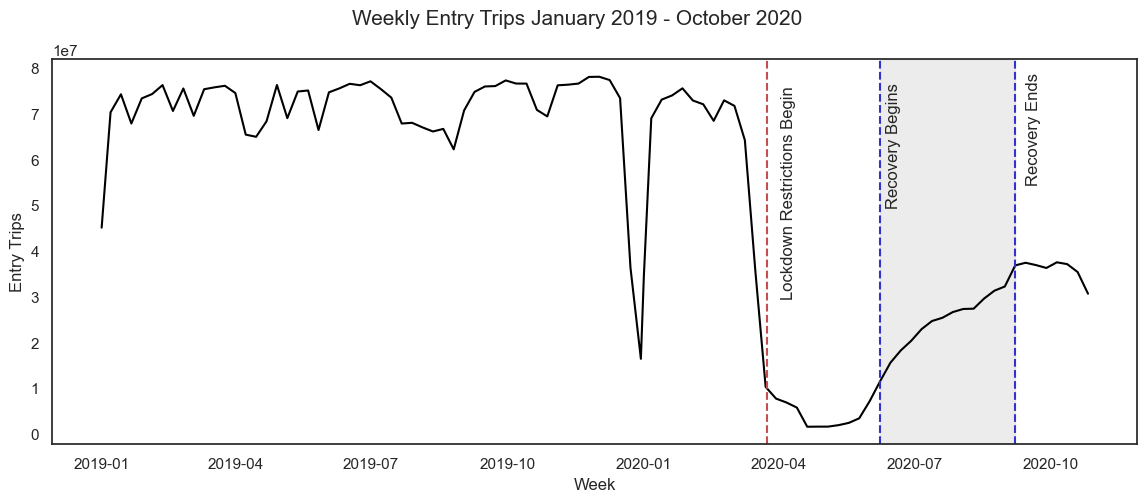

In [17]:
sns.set_context('notebook')

fig, ax = plt.subplots(1, 1, figsize=(14, 5), sharex=False, sharey=False)


df = pt_msoawk
df = df[(df['week_beg']>='01/01/2019')&(df['week_beg']<='10/30/2020')]
df = df.groupby(['week_beg'])['origin_trips'].agg('sum')
df = pd.DataFrame(df).reset_index()

p = sns.lineplot(data = df, x = "week_beg", y = "origin_trips", ci = None, color = 'black')

ax.axvspan(date2num(datetime(2020,6,8)), date2num(datetime(2020,9,7)), color="grey", alpha=0.15)
ax.axvline(date2num(datetime(2020,3,24)), color='r', ls='--')
ax.axvline(date2num(datetime(2020,6,8)), color='#3333CC', ls='--')
ax.axvline(date2num(datetime(2020,9,7)), color='#3333CC', ls='--')

plt.text(date2num(datetime(2020,4,2)), 30000000, "Lockdown Restrictions Begin", rotation='vertical', fontsize=12)
plt.text(date2num(datetime(2020,6,12)), 50000000, "Recovery Begins", rotation='vertical', fontsize=12)
plt.text(date2num(datetime(2020,9,14)), 55000000, "Recovery Ends", rotation='vertical', fontsize=12)


fig.suptitle('Weekly Entry Trips January 2019 - October 2020', fontsize=15)
plt.ylabel("Entry Trips")
plt.xlabel("Week")

#plt.ticklabel_format(style='plain', axis='y')
#p.set_xticklabels(labels = df['week_beg'], rotation=45)

plt.savefig('../figures/weeklytrips.jpeg', dpi = 300)
plt.show()

C:\Users\TBD\.conda\envs\dissertation2\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


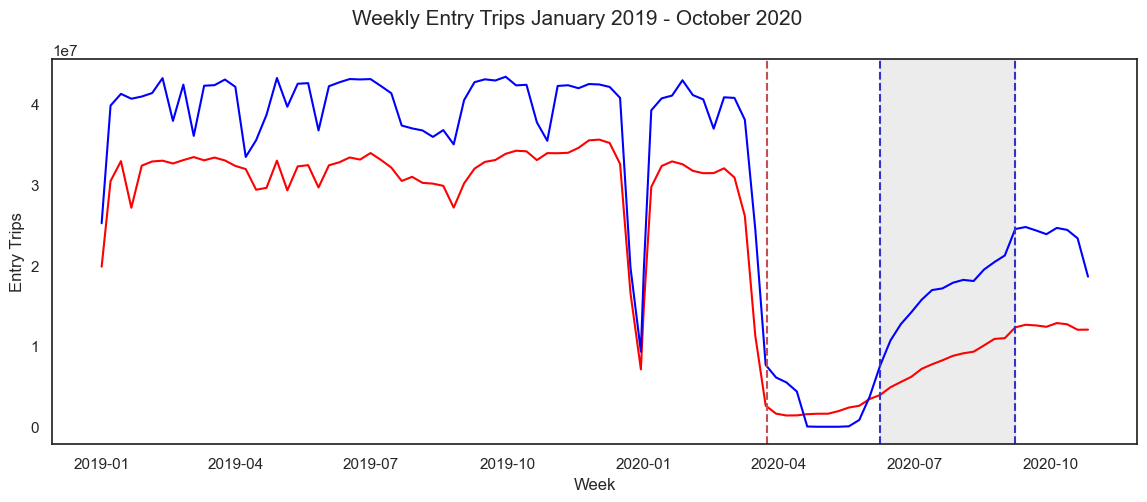

In [18]:
sns.set_context('notebook')

fig, ax = plt.subplots(1, 1, figsize=(14, 5), sharex=False, sharey=False)


df = pt_msoawk
df = df[(df['week_beg']>='01/01/2019')&(df['week_beg']<='10/30/2020')]
df = df.groupby(['week_beg'])['origin_rail', 'origin_bus'].agg('sum')
df = pd.DataFrame(df).reset_index()

p = sns.lineplot(data = df, x = "week_beg", y = "origin_rail", ci = None, color = 'red')
q = sns.lineplot(data = df, x = "week_beg", y = "origin_bus", ci = None, color = 'blue')

ax.axvspan(date2num(datetime(2020,6,8)), date2num(datetime(2020,9,7)), color="grey", alpha=0.15)
ax.axvline(date2num(datetime(2020,3,24)), color='r', ls='--')
ax.axvline(date2num(datetime(2020,6,8)), color='#3333CC', ls='--')
ax.axvline(date2num(datetime(2020,9,7)), color='#3333CC', ls='--')

#plt.text(date2num(datetime(2020,4,2)), 30000000, "Lockdown Restrictions Begin", rotation='vertical', fontsize=12)
#plt.text(date2num(datetime(2020,6,12)), 50000000, "Recovery Begins", rotation='vertical', fontsize=12)
#plt.text(date2num(datetime(2020,9,14)), 55000000, "Recovery Ends", rotation='vertical', fontsize=12)


fig.suptitle('Weekly Entry Trips January 2019 - October 2020', fontsize=15)
plt.ylabel("Entry Trips")
plt.xlabel("Week")
plt.show();
#plt.ticklabel_format(style='plain', axis='y')
#p.set_xticklabels(labels = df['week_beg'], rotation=45)

#plt.savefig('../figures/weeklytrips.png')

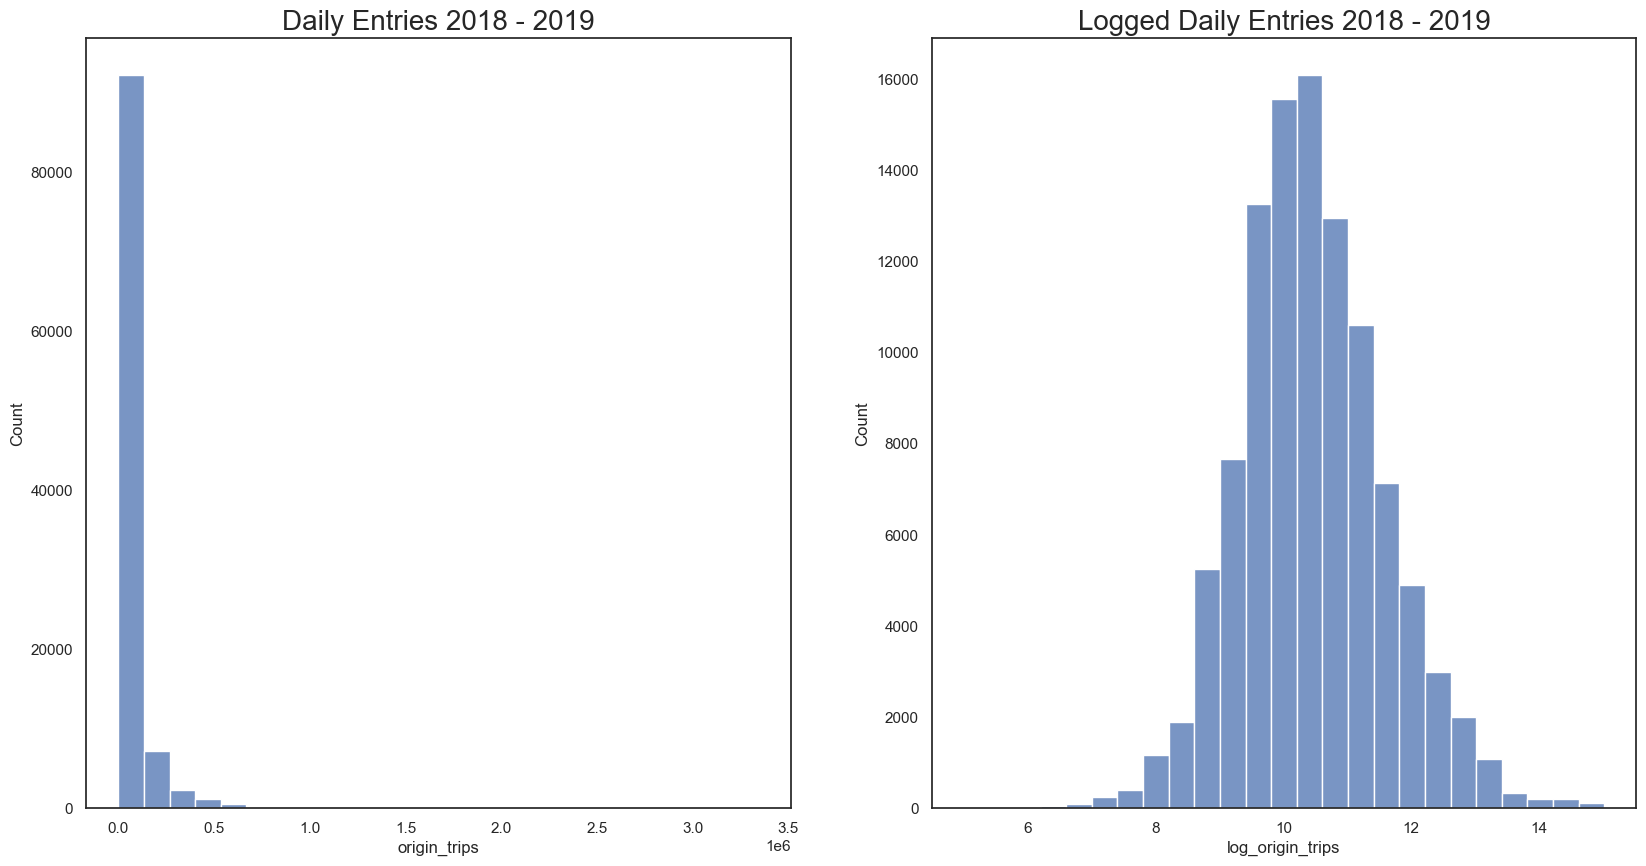

In [19]:
# Histogram of origin_trips, clearly we need to log transform the trips.

fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=False, sharey=False)

df = pt_msoawk

df = df.reset_index() #msoa appears to have a more normal distribution, important to highlight
df = df[(df['week_beg']>='01/01/2018')&(df['week_beg']<='12/31/2019')]

p = sns.histplot(data=df, x='origin_trips', bins = 25, ax=ax[0])
q = sns.histplot(data=df, x='log_origin_trips', bins = 25, ax=ax[1])
p.set_title("Daily Entries 2018 - 2019", fontsize = 20)
q.set_title("Logged Daily Entries 2018 - 2019", fontsize = 20)
plt.show()

In [20]:
# Conduct a Dickey Fuller (Unit Root) test for stationarity to prove what we are seeing visually.
# Null hypothesis is that the time series is non-stationary
# P-value is less than .05, and the null hypothesis is rejected. Therefore, this data is stationary..
# https://www.machinelearningplus.com/time-series/time-series-analysis-python/

#df = rail_la[(rail_la['date']>='01/01/2017')&(rail_la['date']<='12/31/2019')]
df = pt_msoawk
df = df[(df['week_beg']>='01/01/2018')&(df['week_beg']<='12/31/2019')]

result = adfuller(df['log_origin_trips'].values, autolag = 'AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical Values:')
    print(f'  {key}, {value}')

ADF Statistic: -17.737489322616966
p-value: 3.4136384314287335e-30
Critical Values:
  1%, -3.4304128661377113
Critical Values:
  5%, -2.861567785859786
Critical Values:
  10%, -2.56678478943881


### Modelling Time Series

In [22]:
# Create a dataframe for 2020 that contains all the MSOAs from 2019 (we lose a lot in 2020 due to not tracking Bus ridership when fares were cut)
df = pt_msoawk
df2 = pt_msoawk

# Master of all week/msoa combinations
#df = df[(df['week_beg']>='12/03/2018')&(df['week_beg']<='12/02/2019')&(df['week']!=53)] #excluding 53 as 2020 does not have one.
df = df[(df['week']!=53)]
df = df[['week', 'msoa_code', 'msoa_name', 'la_code', 'la_name', 'geometry']].drop_duplicates()

# Collect 2020 data to measure actuals vs. predicted
df2 = df2[(df2['week_beg']>='12/09/2019')&(df2['week_beg']<='10/26/2020')]

# get week and year for msoas without transaction data to populate with zero
df3 = df2[['week', 'year', 'week_beg']].drop_duplicates()

# populate master data frame with 2020 information that exists.
master_2020 = df.merge(df2, how='left', left_on = ['week', 'msoa_code', 'msoa_name', 'la_code', 'la_name', 'geometry'],
                       right_on = ['week', 'msoa_code', 'msoa_name', 'la_code', 'la_name', 'geometry'])

# Find all blank rows that need to be filled with zero, but above should do that for us now.
master_2020 = master_2020.merge(df3, how = 'right', left_on = ['week'], right_on = ['week'])

fill_cols = ['origin_trips', 'origin_mth', 'origin_fss', 'origin_rail', 'origin_bus', 'destination_rail', 'log_origin_trips', 'log_origin_mth', 'log_origin_fss', 'log_destination_rail']
for i in range(0, len(fill_cols)):
    master_2020[fill_cols[i]] = master_2020[fill_cols[i]].fillna(0)

master_2020 = master_2020[['year_y',
                           'week',
                           'week_beg_y',
                           'msoa_code',
                           'msoa_name',
                           'la_code',
                           'la_name',
                           'geometry',
                           'origin_trips',
                           'origin_mth',
                           'origin_fss',
                           'origin_rail',
                           'origin_bus',
                           'destination_rail',
                           'log_origin_trips',
                           'log_origin_mth',
                           'log_origin_fss',
                           'log_destination_rail']]

master_2020 = master_2020.rename({'year_y':'year', 'week_beg_y': 'week_beg'}, axis=1)

#master_2020.info()

In [23]:
# Create a 2020 estimate based on 2019
pt_msoawk['week'] = pd.to_numeric(pt_msoawk['week'])

# Limit Rail to 2019
df = pt_msoawk
df = df[(df['week_beg']>='12/03/2018')&(df['week_beg']<='12/02/2019')] # Weeks 2018-49 to 2019-48
df_train = df[['week', 'msoa_name', 'log_origin_trips', 'log_origin_mth', 'log_origin_fss']]
df_train = df_train.rename({'log_origin_trips':'estimate_log_origin',
                           'log_origin_mth': 'estimate_log_origin_mth',
                           'log_origin_fss': 'estimate_log_origin_fss'}, axis = 1)

# Establish 2020 estimate
df = pt_msoawk
df = df[(df['week_beg']>='12/03/2018')&(df['week_beg']<='12/02/2019')] # Weeks 2019-49 to 2020-48
df = df[['week', 'msoa_code', 'msoa_name', 'la_code', 'la_name']]
df = df.merge(df_train, left_on = ['week', 'msoa_name'], right_on = ['week', 'msoa_name'])
df['estimate_origin'] = np.exp(df['estimate_log_origin'])
df['estimate_origin_mth'] = np.exp(df['estimate_log_origin_mth'])
df['estimate_origin_fss'] = np.exp(df['estimate_log_origin_fss'])
df['year'] = df['week'].apply(lambda x: 2019 if x >= 48 else 2020) # slight problem that 2018 has week 53, 2019 does not.

df_estimate = df[['year','week', 'msoa_code', 'estimate_log_origin', 'estimate_origin', 'estimate_origin_mth', 'estimate_origin_fss']]

# merge back to original dataset, but append a 2020 'masterframe' and then fillna with zero
df = pt_msoawk[pt_msoawk['week_beg']<='12/02/2019']
df = df.append(master_2020)
df['week'] = pd.to_numeric(df['week'])
df = df.merge(df_estimate, how = 'left', left_on = ['year', 'week', 'msoa_code'], right_on = ['year','week', 'msoa_code'])
df['estimate_log_origin'] = df['estimate_log_origin'].fillna(0)
df['estimate_origin'] = df['estimate_origin'].fillna(0)
df['estimate_origin_mth'] = df['estimate_origin_mth'].fillna(0)
df['estimate_origin_fss'] = df['estimate_origin_fss'].fillna(0)
# only pull rows that are not zero as this will drive infinities
#df = df[df['estimate_origin']!=0]
df['residuals'] = df['estimate_origin'] - df['origin_trips']
df['residuals_mth'] = df['estimate_origin_mth'] - df['origin_mth']
df['residuals_fss'] = df['estimate_origin_fss'] - df['origin_fss']

#df.head()

pt_msoaest = df

In [24]:
df['origin_trips'].agg('sum')

12997486423.0

In [25]:
df['origin_mth'].agg('sum') + df['origin_fss'].agg('sum')

12997486423.0

In [26]:
df = pt_msoawk
df2 = pt_msoaest

#df2 = df2[(df2['week_beg']>='04/01/2020')&(df2['week_beg']<='06/30/2020')].groupby(['week_beg'])['estimate_origin'].agg('sum')
#df = df[(df['week_beg']>='04/01/2019')&(df['week_beg']<='06/30/2019')].groupby(['week_beg'])['origin_trips'].agg('sum').reset_index()

df2 = df2[(df2['week_beg']>='01/01/2020')&(df2['week_beg']<='10/26/2020')].groupby(['week_beg', 'week']).agg({'origin_trips':'sum',
                                                                                                      'origin_mth':'sum',
                                                                                                      'origin_fss':'sum',
                                                                                                      'estimate_origin':'sum',
                                                                                                      'msoa_name':'count'}).reset_index()

#df2

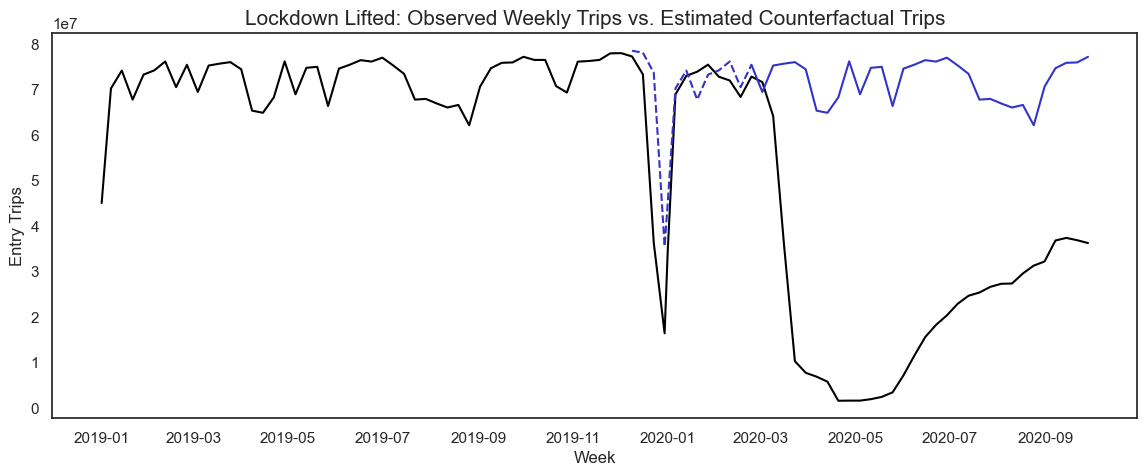

In [27]:
sns.set_context('notebook')

df = pt_msoawk
df2 = pt_msoaest
df3 = pt_msoaest

df = df[(df['week_beg']>='01/01/2019')&(df['week_beg']<='09/28/2020')].groupby(['week_beg'])['origin_trips'].agg('sum')
df = pd.DataFrame(df)
df = df.reset_index()

df2 = df2[(df2['week_beg']>='12/09/2019')&(df2['week_beg']<='02/24/2020')].groupby(['week_beg'])['estimate_origin'].agg('sum')
df2 = pd.DataFrame(df2)
df2 = df2.reset_index()

df3 = df3[(df3['week_beg']>='02/24/2020')&(df3['week_beg']<='09/28/2020')].groupby(['week_beg'])['estimate_origin'].agg('sum')
df3 = pd.DataFrame(df3)
df3 = df3.reset_index()


fig, ax = plt.subplots(1, 1, figsize=(14, 5), sharex=False, sharey=False)
plt.plot(df.week_beg, df.origin_trips, color = 'black')
plt.plot(df2.week_beg, df2.estimate_origin, color = '#3333CC', ls='--')
plt.plot(df3.week_beg, df3.estimate_origin, color = '#3333CC')
ax.set_title('Lockdown Lifted: Observed Weekly Trips vs. Estimated Counterfactual Trips', fontsize = 15)

plt.ylabel("Entry Trips")
plt.xlabel("Week")
plt.show()

#plt.savefig('../figures/counterfactual_estimate.png')

<Figure size 640x480 with 0 Axes>

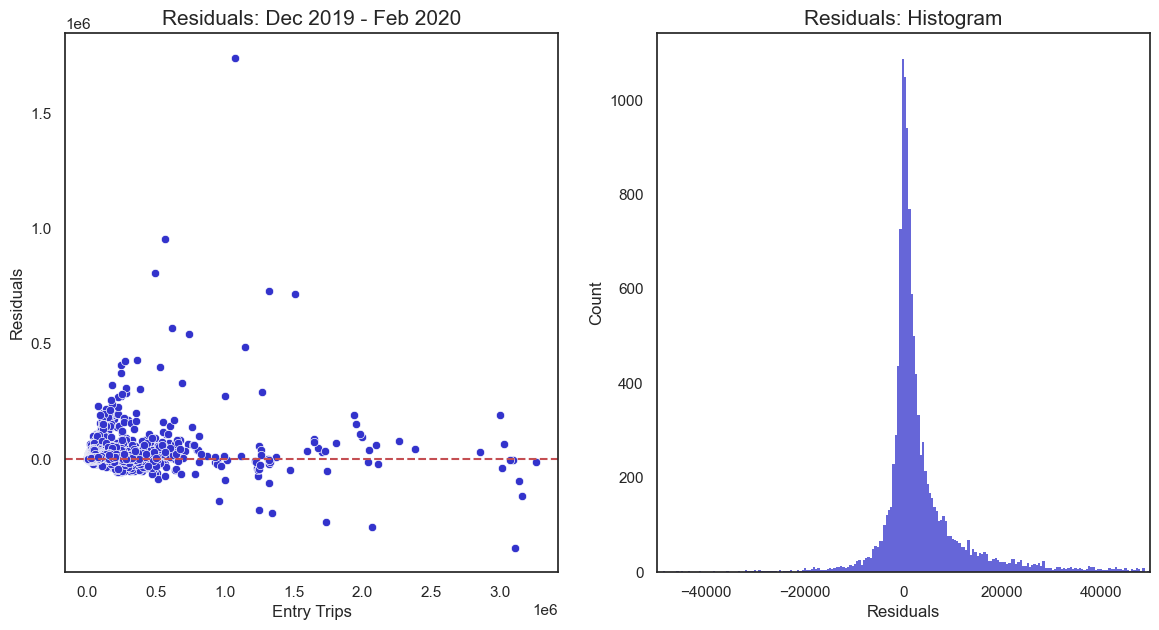

In [28]:
sns.set_context('notebook')

# Plotting of residuals against existing model, not forecasted values.
fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharex=False, sharey=False)

df = pt_msoaest
df = df[(df['week_beg']>='12/09/2019')&(df['week_beg']<='02/24/2020')]

p = sns.scatterplot(x = "origin_trips", y = "residuals", data = df, ax=ax[0], color = '#3333CC')
ax[0].axhline(y=0, color='r', ls='--')

q = sns.histplot(data=df, x='residuals', color = '#3333CC')

ax[0].set_title('Residuals: Dec 2019 - Feb 2020', fontsize = 15)
ax[0].set_ylabel("Residuals")
ax[0].set_xlabel("Entry Trips")


ax[1].set_title('Residuals: Histogram', fontsize = 15)
#ax[1].set_ylim(0,800)
ax[1].set_xlim(-50000,50000)
ax[1].set_xlabel("Residuals")

plt.show()
#plt.savefig('../figures/residuals_distribution.png')

In [29]:
# Check for forecast accuracy
# https://www.machinelearningplus.com/vector-autoregression-examples-python/
# Durbin Watson Statistic for serial correlation of errors of model
# https://www.machinelearningplus.com/vector-autoregression-examples-python/
# Calculate r-squared
# https://www.kite.com/python/answers/how-to-calculate-r-squared-with-numpy-in-python

df = pt_msoaest
df = df[(df['week_beg']>='12/09/2019')&(df['week_beg']<='02/24/2020')]

correlation_matrix = np.corrcoef(df['estimate_origin'], df['origin_trips'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2


res = df['residuals']**2
RMSE = round(sqrt(res.mean()), 3)
MAPE = np.mean(np.abs(df['residuals'])/np.abs(df['origin_trips']))
out = durbin_watson(df['residuals'])

d = {'Forecast Test':['R-Squared','RMSE', 'MAPE', 'Durbin-Watson'], 'Value':[r_squared, RMSE, MAPE, out]}
df = pd.DataFrame(d)
df

,Forecast Test,Value
0,R-Squared,0.96
1,RMSE,"32,080.93"
2,MAPE,0.25
3,Durbin-Watson,1.38


In [30]:
#Table to compare actual trips versus estimates
pt_msoawk['week'] = pd.to_numeric(pt_msoawk['week'])
pt_msoaest['week'] = pd.to_numeric(pt_msoaest['week'])
#pt_msoawk_ols_test['week'] = pd.to_numeric(pt_msoawk_ols_test['week'])

trips_2018 = pt_msoawk[(pt_msoawk['year']==2018)&(pt_msoawk['week']>=12)&(pt_msoawk['week']<=39)]['origin_trips'].agg('sum')
trips_2019 = pt_msoawk[(pt_msoawk['year']==2019)&(pt_msoawk['week']>=12)&(pt_msoawk['week']<=39)]['origin_trips'].agg('sum')
trips_2020 = pt_msoawk[(pt_msoawk['year']==2020)&(pt_msoawk['week']>=12)&(pt_msoawk['week']<=39)]['origin_trips'].agg('sum')
trips_est_2020 = pt_msoaest[(pt_msoaest['year']==2020)&(pt_msoaest['week']>=12)&(pt_msoaest['week']<=39)]['estimate_origin'].agg('sum')
#trips_ols_2020 = pt_msoawk_ols_test[(pt_msoawk_ols_test['year']==2020)&(pt_msoawk_ols_test['week']>=12)&(pt_msoawk_ols_test['week']<=39)]['estimate'].agg('sum')


d = {'Trips Week 12 to Week 39':[2018, 2019, '2020 Prediction: Equal to LY','2020 Actual'], 'Value':[trips_2018, trips_2019, trips_est_2020, trips_2020]}
df = pd.DataFrame(d)
df

,Trips Week 12 to Week 39,Value
0,2018,"1,992,349,780.00"
1,2019,"2,011,615,637.00"
2,2020 Prediction: Equal to LY,"2,011,615,637.00"
3,2020 Actual,"511,054,493.00"


In [31]:
# Table validation that 2020 trips are exactly equal to 2019
pt_orig = pt_msoawk[(pt_msoawk['week_beg']>='03/01/2019')&(pt_msoawk['week_beg']<='09/30/2019')].groupby(['week','week_beg']).agg({'origin_trips': 'sum', 'msoa_name': 'count'})
pt_ly = pt_msoaest[(pt_msoaest['week_beg']>='03/01/2020')&(pt_msoaest['week_beg']<='09/30/2020')].groupby(['week','week_beg']).agg({'estimate_origin': 'sum', 'msoa_name': 'count'})
pt_origly = pt_orig.merge(pt_ly, how = 'left', left_on = 'week', right_on = 'week')
#pt_origly

In [32]:
# Export to CSV
df = pt_msoaest
#df.to_csv('../output_data/pt_msoaest.csv', index = False)